#**SOURCE CODE FOR TASK 2 (CODE GENERATION FOR PYTHON)**

Siddhartha Kumar

**NOTE:**  *Due to the use of multiple notebooks to complete this project I have saved my files in hugging face so that I can run the code in different notebooks at the same time Its will be possible to run the whole code at onces but if any error occur use the hugging Face id-LLMLover/"dataset names" and LLMLover/"Model Name" for references*

In [1]:
 #start by uploading all the required libaries

!pip install transformers==4.38.2
!pip install datasets
!pip install accelerate==0.27.2
!pip install -q -U bitsandbytes
!pip install git+https://github.com/huggingface/trl.git@7630f877f91c556d9e5a3baa4b6e2894d90ff84c
!pip install peft==0.4.0
!pip install -q streamlit
!pip install codebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggi

In [2]:

!nvidia-smi

Sun Apr 28 21:45:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
import os
import torch
from datasets import load_dataset,Dataset,concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel,prepare_model_for_kbit_training,get_peft_model,AutoPeftModelForCausalLM
from trl import SFTTrainer
from codebleu import calc_codebleu
import streamlit as st

In [ ]:
# Name of The Model That will be used as Pretrained model
model_name = "NousResearch/Llama-2-7b-hf"
# The Benchmark datasets
dataset_name = "Muennighoff/mbpp"

## **LOAD THE DATASET(FOR THIS PROJECTS SELECTED DATASET IS MBPP)**
## **LOAD THE MODEL(LLAMA-2)**

In [ ]:
def load_model_and_tokenizer():
  compute_dtype = getattr(torch, "float16")

  bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                                                    #config for Qunatized model
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
  )

  model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
  model.config.use_cache = False
  model.config.pretraining_tp = 1

  # Load LLaMA tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"

  return model,tokenizer


In [ ]:
def Custom_Prompt_for_Code_Gen(sample):
    """
    The sample prompt will as flow :
    Below is an Python Programing question that describes a task. Write a Code for the same:

    Input: Write a python function to count numbers whose oth and nth bits are set.

    ### Response:
    def count_Num(n):
       if (n == 1):
       return 1
   count = pow(2,n - 2)
   return count

   ### End


    """

    Introduction_Sentence = "Below is an Python Programing question that describes a task. Write a Code for the same:"
    user_Input = "Input:"
    Response_Text = "### Response:"
    end_ouput = "### End"

    Introduction = f"{Introduction_Sentence}"
    input_context = f"{user_Input}\n{sample['text']}"
    response = f"{Response_Text}\n{sample['code']}"
    end = f"{end_ouput}"

    parts = [part for part in [Introduction,input_context, response, end] if part]

    sample['formatted_prompt'] = "\n\n".join(parts)
    #sample["combined_text"] = formatted_prompt
    return sample

In [ ]:
def Loading_and_split():
  dataset = load_dataset(dataset_name, split="test").train_test_split(test_size=0.25)
  valid_train_dataset=dataset['train'].train_test_split(test_size=0.35)
  return valid_train_dataset,dataset['test']

valid_train_dataset,test_benchmark_data=Loading_and_split()
train_data=valid_train_dataset['train'].shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list'])
valid_data=valid_train_dataset['test'].shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list'])

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

In [ ]:
print(test_benchmark_data)
print(valid_train_dataset)

Dataset({
    features: ['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list'],
    num_rows: 244
})
DatasetDict({
    train: Dataset({
        features: ['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list'],
        num_rows: 474
    })
    test: Dataset({
        features: ['task_id', 'text', 'code', 'test_list', 'test_setup_code', 'challenge_test_list'],
        num_rows: 256
    })
})


In [ ]:
model_A,tokenizer=load_model_and_tokenizer()
conf = model_A.config
conf

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

LlamaConfig {
  "_name_or_path": "NousResearch/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "ro

In [ ]:
# def default_model_print(model,tokenizer,data):
#   prompt = f"""
#     [INST]
#     <<SYS>>
#     You are a BEST AI to genrate Python code
#     <</SYS>>
#     {data['text']}
#     [/INST]
#     """.strip()
#   encoding = tokenizer(prompt, return_tensors="pt")
#   with torch.inference_mode():
#       outputs = model.generate(
#         input_ids=encoding.input_ids,
#         attention_mask=encoding.attention_mask,
#         max_new_tokens=512,do_sample=True, temperature=0.6, top_p=0.6
#       )
#   output_code=tokenizer.decode(outputs[0][len(encoding['input_ids'][0]):], skip_special_tokens=True)

#   return output_code


# print(default_model_print(model_A,tokenizer,test_benchmark_data[2]))

## **INTILAIZATION OF MODEL**

In [ ]:


# Number of training epochs
num_train_epochs = 2

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.2

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 30

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

LORA CONFIG

lora_r = 64

lora_alpha = 16

lora_dropout = 0.1

In [ ]:
def intialialize_lora_configration(model):
  model = prepare_model_for_kbit_training(model)
  peft_config = LoraConfig(
      lora_alpha=16,
      lora_dropout=0.1,
        target_modules=[
  "q_proj",
  "k_proj",
      "v_proj",
    "o_proj",
  "gate_proj",
  "up_proj",
  "down_proj",
  "lm_head",
    ],

    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

  model = get_peft_model(model, peft_config)

  return model,peft_config

In [ ]:
# Set training parameters

def set_the_trainning(model,tokenizer,peft_config,train_data,valid_data,output_dir):
  training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
  trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=valid_data,
    dataset_text_field='formatted_prompt',
    peft_config=peft_config,
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
  trainer.train()
  return trainer

##**OUTPUT REGENRATION**

In [ ]:

import re
import textwrap
def new_output(sample,model,tokenizer):
  Introduction_Sentence = "Below is an Python Programing question that describes a task. Write a Code for the same:"
  user_Input = "Input:"
  Response_Text = "### Response:"

  Introduction = f"{Introduction_Sentence}"
  input_context = f"{user_Input}\n{sample['text']}"
  response = f"{Response_Text}\n"

  parts = [part for part in [Introduction,input_context, response] if part]
  #print(parts)

  prompt= "\n\n".join(parts)
  input_ids = tokenizer(prompt, return_tensors='pt',padding=True,truncation=True)
  outputs = model.generate(**input_ids,
        max_new_tokens=256, temperature=0.7, top_p=0.6

    )
  output= tokenizer.decode(outputs[0][len(input_ids["input_ids"][0]):], skip_special_tokens=True)
  pattern = r'def\s+\w+\([^)]*\):\s*([\s\S]*?)\s*### End' ###r"def\s+(\w+)\s*\((.*)\):\s*return\s*(.*)"
  pattern_2 = r'from\s+(\w+(\.\w+)*)\s*import\s+(\w+(,\s*\w+)*)\s*(as\s+\w+)?(?:,\s*(\w+(,\s*\w+)*)\s*(as\s+\w+)?)*'

# Search for the def statement using the regular expression
  match = re.search(pattern, output.strip())
  match_2 = re.search(pattern_2, output.strip())

# Extract the def statement if a match is found
  if match:
    def_statement = match.group(0)
    if match_2:
        extra_code=match_2.group(0)
        combined_code = extra_code + "\n" + def_statement
        sample['output']=textwrap.dedent(combined_code)
    else:
        sample['output']=textwrap.dedent(def_statement)

  else:
    match = re.search(r"def\s+(\w+)\s*\((.*)\):\s*return\s*(.*)", output.strip())
    if match:
        def_statement = match.group(0)
        if match_2:
            extra_code=match_2.group(0)
            combined_code = extra_code + "\n" + def_statement
            sample['output']=textwrap.dedent(combined_code)
        else:
            sample['output']=textwrap.dedent(def_statement)
    else:
        sample['output']="INVALID CODE ERROR WITH THE VALUE "

  sample['unfilter']=output.strip()
  return sample


# f=test_benchmark_data.map(new_output)


## **MODEL_B CONFIGRATION**

In [ ]:
model_A,tokenizer=load_model_and_tokenizer()
model,peft_config=intialialize_lora_configration(model_A)
trainer=set_the_trainning(model,tokenizer,peft_config,train_data,valid_data,"MODEL_B_RUN")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/474 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Step,Training Loss
30,1.025200
60,0.659700
90,0.639100
120,0.638200
150,0.533700
180,0.488200
210,0.489900


In [ ]:
new_model_name_B = "MODEL_B"
trainer.model.save_pretrained(new_model_name_B)
tokenizer.save_pretrained(new_model_name_B)

('MODEL_B/tokenizer_config.json',
 'MODEL_B/special_tokens_map.json',
 'MODEL_B/tokenizer.model',
 'MODEL_B/added_tokens.json',
 'MODEL_B/tokenizer.json')

In [ ]:
#LLMLover/MODEL_EPOCHS_B2_testcase_1   #use this for model B
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
from functools import partial
Model_B = AutoPeftModelForCausalLM.from_pretrained(new_model_name_B,torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(new_model_name_B)
temp_function=partial(new_output,model=Model_B,tokenizer=tokenizer)
test_benchmark_data_code_Model_B=test_benchmark_data.map(temp_function)

In [ ]:
# #dataset_name = "LLMLover/Testing_data12_A_23"
# #test_benchmark_data_code_Model_B = load_dataset("LLMLover/Testing_data12_B_23")['test']
# from codebleu import calc_codebleu
# result = calc_codebleu(test_benchmark_data_code_Model_B['code'],test_benchmark_data_code_Model_B['output'], lang="python", weights=(0.25, 0.25, 0.25, 0.25))
# print(result)

{'codebleu': 0.012713949088107662, 'ngram_match_score': 0.00018838624123508518, 'weighted_ngram_match_score': 0.0008339972451668676, 'syntax_match_score': 0.020121028744326776, 'dataflow_match_score': 0.029712384121701924}


## **GENRATE AND COMBINE DATASETS SYNTHESIS**



In [ ]:
import requests
import json
AWS_API_KEY = "38ED56FED62444439E90C2D855304844"
def llama_generate(prompt,
                   api_token,
                   max_gen_len = 512,
                   temperature = 0.5,
                   top_p =0.9):
  url = 'https://6xtdhvodk2.execute-api.us-west-2.amazonaws.com/dsa_llm/generate'
  body = {
    "prompt": prompt,
    "max_gen_len": max_gen_len,
    "temperature": temperature,
    "top_p": top_p,
    "api_token": api_token
  }
  res = requests.post(url,  json = body)
  return  json.loads(res.text)["body"]["generation"]

In [ ]:
import pandas as pd
data=[]
import json
import time
i=0
for j in range(1):
  time.sleep(20)
  for prompt in ["""
Give me 6 python code using the following template for each Question.

# Question: Write a function to find the similar elements from the given two tuple lists.

# Code: def similar_elements(test_tup1, test_tup2): \n res = tuple(set(test_tup1) & set(test_tup2)) \n return (res)

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a python function to identify non-prime numbers.

# Code: import math def is_not_prime(n): result = False for i in range(2,int(math.sqrt(n)) + 1): if n % i == 0: result = True return result

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to get the n smallest items from a dataset.

# Code: import heapq def small_nnum(list1,n): smallest=heapq.nsmallest(n,list1) return smallest

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to count the most common words in a dictionary.

# Code: from collections import Counter def count_common(words): word_counts = Counter(words) top_four = word_counts.most_common(4) return (top_four)

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to split the given string with multiple delimiters by using regex.

# Code: import re def multiple_split(text): return (re.split('; |, |\*|\n',text))

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a python function to multiply all items in the list.

# Code: def multiply_list(items): tot = 1 for x in items: tot *= x return tot

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to find the length of the shortest string that has both str1 and str2 as subsequences.

# Code: def super_seq(X, Y, m, n): if (not m): return n if (not n): return m if (X[m - 1] == Y[n - 1]): return 1 + super_seq(X, Y, m - 1, n - 1) return 1 + min(super_seq(X, Y, m - 1, n), super_seq(X, Y, m, n - 1))

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to find the maximum number of segments of lengths a, b and c that can be formed from n.

# Code: def maximum_segments(n, a, b, c) : dp = [-1] * (n + 10) dp[0] = 0 for i in range(0, n) : if (dp[i] != -1) : if(i + a <= n ): dp[i + a] = max(dp[i] + 1, dp[i + a]) if(i + b <= n ): dp[i + b] = max(dp[i] + 1, dp[i + b]) if(i + c <= n ): dp[i + c] = max(dp[i] + 1, dp[i + c]) return dp[n]

####


""","""
Give me 6 python code using the following template for each Question.

# Question: Write a function to find the minimum total path sum in the given triangle.

# Code: def min_sum_path(A): memo = [None] * len(A) n = len(A) - 1 for i in range(len(A[n])): memo[i] = A[n][i] for i in range(len(A) - 2, -1,-1): for j in range( len(A[i])): memo[j] = A[i][j] + min(memo[j], memo[j + 1]) return memo[0]
####


"""]:
    time.sleep(20)
    print(prompt)
    d=llama_generate(prompt, AWS_API_KEY)
    for sol in d.split("####"):
      try:
        if sol.split("# Question:")[1].split("\n\n")[0].strip()!='' and sol.split("# Code:")[1].strip()!='':
          i=i+1
          Question  = sol.split("# Question:")[1].split("\n\n")[0].strip()
          Code=sol.split("# Code:")[1].strip()
          data.append({'ID':i,'Text':Question,'Code':Code})
      except:
        print("No value")
# with open(f'Final_data{j}.json', 'w') as f:
#     json.dump(data, f)

with open('Final_data.json', 'w') as f:
    json.dump(data, f)


Give me 6 python code using the following template for each Question.

# Question: Write a function to find the similar elements from the given two tuple lists.

# Code: def similar_elements(test_tup1, test_tup2): 
 res = tuple(set(test_tup1) & set(test_tup2)) 
 return (res)

####




Give me 6 python code using the following template for each Question.

# Question: Write a python function to identify non-prime numbers.

# Code: import math def is_not_prime(n): result = False for i in range(2,int(math.sqrt(n)) + 1): if n % i == 0: result = True return result

####




Give me 6 python code using the following template for each Question.

# Question: Write a function to get the n smallest items from a dataset.

# Code: import heapq def small_nnum(list1,n): smallest=heapq.nsmallest(n,list1) return smallest

####




Give me 6 python code using the following template for each Question.

# Question: Write a function to count the most common words in a dictionary.

# Code: from collections

In [ ]:
# Create a list of all the JSON files that you want to combine.
import json
json_files = ["Final_data.json"]

# Create an empty list to store the Python objects.
python_objects = []

# Load each JSON file into a Python object.
for json_file in json_files:
    with open(json_file, "r") as f:
        for each_line in json.load(f):
            python_objects.append(each_line)


with open("Systensis_data.json", "w") as f:
    json.dump(python_objects, f, indent=4)


Dataset.from_list(python_objects)

Dataset({
    features: ['ID', 'Text', 'Code'],
    num_rows: 39
})

In [ ]:
# test_benchmark_data_code_Model_B = load_dataset("LLMLover/Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")['test']
sync_data = Dataset.from_list(python_objects).train_test_split(test_size=0.30)
sync_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Text', 'Code'],
        num_rows: 27
    })
    test: Dataset({
        features: ['ID', 'Text', 'Code'],
        num_rows: 12
    })
})

In [ ]:
sync_data['train']=sync_data['train'].rename_columns({"Text":"text","Code":"code"})
sync_data['test']=sync_data['test'].rename_columns({"Text":"text","Code":"code"})

In [ ]:
sync_train_data=sync_data['train'].shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['ID', 'text', 'code'])
sync_valid_data=sync_data['test'].shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['ID', 'text', 'code'])

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

##**MODEL C CONFIRATION**


In [ ]:
sync_train_data=load_dataset("LLMLover/Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")['train'].rename_columns({"Text":"text","Code":"code"})
sync_valid_data=load_dataset("LLMLover/Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")['test'].rename_columns({"Text":"text","Code":"code"})

Generating train split:   0%|          | 0/1717 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/736 [00:00<?, ? examples/s]

In [ ]:
print(sync_train_data)
print(sync_valid_data)

Dataset({
    features: ['ID', 'text', 'code'],
    num_rows: 1717
})
Dataset({
    features: ['ID', 'text', 'code'],
    num_rows: 736
})


In [ ]:
model_A,tokenizer=load_model_and_tokenizer()
sync_train_data_C=sync_train_data.shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['ID', 'text', 'code'])
sync_valid_data_C=sync_valid_data.shuffle(seed=42).map(Custom_Prompt_for_Code_Gen).remove_columns(['ID', 'text', 'code'])
model,peft_config=intialialize_lora_configration(model_A)
trainer=set_the_trainning(model,tokenizer,peft_config,sync_train_data_C,sync_valid_data_C,"MODEL_C_RUN")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1717 [00:00<?, ? examples/s]

Map:   0%|          | 0/736 [00:00<?, ? examples/s]

Step,Training Loss
30,1.007900
60,0.389700
90,0.324800
120,0.332500
150,0.245900
180,0.294100
210,0.300200
240,0.270600
270,0.302400
300,0.232800


In [ ]:
new_model_name_C = "MODEL_C"
trainer.model.save_pretrained(new_model_name_C)
tokenizer.save_pretrained(new_model_name_C)

('MODEL_C/tokenizer_config.json',
 'MODEL_C/special_tokens_map.json',
 'MODEL_C/tokenizer.model',
 'MODEL_C/added_tokens.json',
 'MODEL_C/tokenizer.json')

In [ ]:
#LLMLover/MODEL_EPOCHS_B2_testcase   #use this for Model C as its pretrained
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
from functools import partial
Model_C = AutoPeftModelForCausalLM.from_pretrained(new_model_name_C,torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(new_model_name_C)
temp_function=partial(new_output,model=Model_C,tokenizer=tokenizer)
test_benchmark_data_code_Model_B=test_benchmark_data.map(temp_function)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/bitsandbytes/nn/modules.

##**MODEL D CONFIRATIONS**

In [ ]:
# sync_data.push_to_hub("Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")
# from datasets import load_dataset
# sync_train_data=load_dataset("LLMLover/Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")['train'].rename_columns({"Text":"text","Code":"code"})
# sync_valid_data=load_dataset("LLMLover/Final_Systhesis_data_from_AWS_llama_70b_Task_3_Part2")['test'].rename_columns({"Text":"text","Code":"code"})

Generating train split:   0%|          | 0/1717 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/736 [00:00<?, ? examples/s]

In [ ]:
test_benchmark_data

DatasetDict({
    train: Dataset({
        features: ['ID', 'Text', 'Code'],
        num_rows: 1717
    })
    test: Dataset({
        features: ['ID', 'Text', 'Code'],
        num_rows: 736
    })
})

In [ ]:
print(train_data)
print(sync_train_data)
print(valid_data)
print(sync_valid_data)

In [ ]:
# Concatenate the datasets
concatenated_dataset_train = concatenate_datasets([train_data ,sync_train_data])
concatenated_dataset_valid = concatenate_datasets([valid_data ,sync_valid_data])

In [ ]:
print(concatenated_dataset_train)
print(concatenated_dataset_valid)

Dataset({
    features: ['formatted_prompt'],
    num_rows: 2191
})

In [ ]:
model_A,tokenizer=load_model_and_tokenizer()
model,peft_config=intialialize_lora_configration(model_A)
trainer=set_the_trainning(model,tokenizer,peft_config,concatenated_dataset_train,concatenated_dataset_valid)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/transformers/generation/configur

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Map:   0%|          | 0/2191 [00:00<?, ? examples/s]

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

Step,Training Loss
30,1.124900
60,0.539200
90,0.484800
120,0.444100
150,0.367300
180,0.424000
210,0.370700
240,0.354400
270,0.375800
300,0.327000


In [ ]:
new_model_name_D = "MODEL_D"
trainer.model.save_pretrained(new_model_name_D)
tokenizer.save_pretrained(new_model_name_D)

('MODEL_D2_2_23_04_2024/tokenizer_config.json',
 'MODEL_D2_2_23_04_2024/special_tokens_map.json',
 'MODEL_D2_2_23_04_2024/tokenizer.model',
 'MODEL_D2_2_23_04_2024/added_tokens.json',
 'MODEL_D2_2_23_04_2024/tokenizer.json')

In [ ]:
#LLMLover/MODEL_EPOCHS_D2_testcase_2   #use this as Model is trained
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
from functools import partial
Model_D = AutoPeftModelForCausalLM.from_pretrained(new_model_name_D,torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(new_model_name_D)
temp_function=partial(new_output,model=Model_D,tokenizer=tokenizer)
test_benchmark_data_code_Model_D=test_benchmark_data.map(temp_function)

##**EVALUTION OF THREE MODEL**

In [ ]:
# !pip install datasets
# from datasets import load_dataset,Dataset
# test_benchmark_data_code_Model_A = load_dataset('LLMLover/Testing_data12_A_23')['test']
# test_benchmark_data_code_Model_C = load_dataset('LLMLover/Testing_data12_C_23')['test']
# test_benchmark_data_code_Model_D = load_dataset('LLMLover/Testing_data12_D_23')['test']
# test_benchmark_data_code_Model_B = load_dataset('LLMLover/Testing_data12_B')['test']

In [ ]:

# test_case_str = """
# def test_add():
#     assert unique_words("My name us") == 3
#     # assert unique_words("My name us") == 0
#     # assert unique_words("My name us") == 0
# """

# Combine code and test case
import re
import textwrap

def test_result(sample):
    # print(sample['task_id'])
    pass_=0
    AssertionError_=0
    TypeError_=0
    SyntaxError_=0
    ImportError_=0
    Exception_=0
    test_cases=sample['test_list']
    if isinstance(test_cases, list) and all(isinstance(sublist, list) for sublist in test_cases):
        #print("test_cases is a list of lists")
        flattened_test_cases = [test for sublist in test_cases for test in sublist]
    else:
        #print("test_cases is not a list of lists")
        flattened_test_cases=test_cases
    generated_code =textwrap.indent(sample['output'], '')
    #print(generated_code)
    new_function_name = "v"
    for test in flattened_test_cases:
        combined_code=''
        match_test = re.search(r"assert\s+(\w+)\(", test)
        if match_test:
            old_function_name_function = match_test.group(1)
        else:
            old_function_name_function= new_function_name
    # Replace old function name with new function name
            #test = test.replace(old_function_name_function, new_function_name)
        test_case_str = f"""
def test_add():
    {test}
    print("hi")

test_add()
"""
        match_code1 = re.search( r"def\s+(\w+)\s*\(", generated_code)
        if match_code1:
            old_function_name = match_code1.group(1)
    # Replace old function name with new function name
            generated_code = generated_code.replace(old_function_name, old_function_name_function)
        combined_code = f'''
{generated_code.strip()}

'''
        try:
            exec(combined_code)
            exec(test)
            pass_=pass_ +1
        except AssertionError:
            AssertionError_=AssertionError_ +1
        except SyntaxError as e:
            SyntaxError_=SyntaxError_+1
        except TypeError as e:
            TypeError_=TypeError_+1
        except NameError as e:
            ImportError_=ImportError_+1
        except Exception as e:
            Exception_=Exception_+1


    sample['pass'] = pass_
    sample['TypeError'] = TypeError_
    sample['AssertionError'] = AssertionError_
    sample['SyntaxError'] = SyntaxError_
    sample['ImportError'] = ImportError_
    sample['Exception'] = Exception_



    return sample



In [ ]:
d1=test_benchmark_data['test'].filter(lambda example: example['output'] != "INVALID CODE ERROR WITH THE VALUE ")
d1_=d1.filter(lambda example: example['task_id'] != 126)
try:
    fh1=d1_.map(test_result)
except Exception as e:
    print("Error occurred while executing the code:", e)

Filter:   0%|          | 0/244 [00:00<?, ? examples/s]

Filter:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/239 [00:00<?, ? examples/s]

In [ ]:
d1=test_benchmark_data['test'].filter(lambda example: example['output'] != "INVALID CODE ERROR WITH THE VALUE ")
try:
    fh1=d1.map(test_result)
except Exception as e:
    print("Error occurred while executing the code:", e)

Filter:   0%|          | 0/244 [00:00<?, ? examples/s]

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

In [ ]:
d1=test_benchmark_data['test'].filter(lambda example: example['output'] != "INVALID CODE ERROR WITH THE VALUE ")
try:
    fh1=d1.map(test_result)
except Exception as e:
    print("Error occurred while executing the code:", e)

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [ ]:
d1=test_benchmark_data_code_Model_B['test'].filter(lambda example: example['output'] != "INVALID CODE ERROR WITH THE VALUE ")
d1_=d1.filter(lambda example: example['task_id'] != 558)
try:
    fh1=d1_.map(test_result)
except Exception as e:
    print("Error occurred while executing the code:", e)

Filter:   0%|          | 0/244 [00:00<?, ? examples/s]

Filter:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def Evalution_graph(fh1):
  # Define the data
  Pass = fh1.filter(lambda example: example['pass']>2).num_rows  # Replace with the actual number of cases that have passed
  TypeError = fh1.filter(lambda example: example['TypeError']>2).num_rows
  Failed= fh1.filter(lambda example: example['AssertionError']>2).num_rows
  SyntaxError = fh1.filter(lambda example: example['SyntaxError']>2).num_rows
  ImportError = fh1.filter(lambda example: example['ImportError']>2).num_rows
  Exception = fh1.filter(lambda example: example['Exception']>2).num_rows

  # Create labels and data for the bar chart
  labels = ['Passed','TypeError','Failed','SyntaxError','ImportError','Exception']
  counts = [Pass,TypeError,Failed,SyntaxError,ImportError,Exception]

  # Create a bar chart
  plt.figure(figsize=(8, 6))
  plt.bar(labels, counts, color=['green', 'red', 'blue','grey','yellow','orange'])

  # Add labels and title
  plt.xlabel('Type of Errors')
  plt.ylabel('No of Benchmarks DataSets')
  plt.title('Error Distribution in Dataset')

  # Show the plot
  plt.show()

####**MODEL C**

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

Filter:   0%|          | 0/239 [00:00<?, ? examples/s]

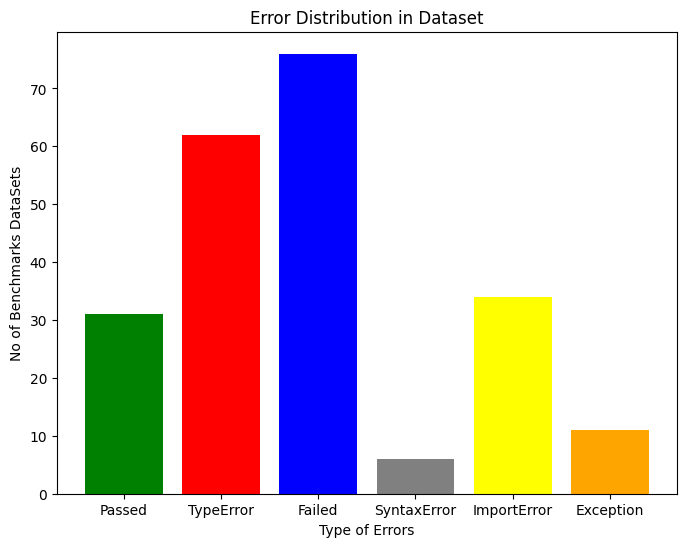

Pass : 31

TypeError : 62

Failed : 76

SyntaxError : 6

ImportError : 34

Exception : 11

Not Eligile for Evalution : 4


In [ ]:
Evalution_graph(fh1)
Pass = fh1.filter(lambda example: example['pass']>2).num_rows  # Replace with the actual number of cases that have passed
TypeError = fh1.filter(lambda example: example['TypeError']>2).num_rows
Failed= fh1.filter(lambda example: example['AssertionError']>2).num_rows
SyntaxError = fh1.filter(lambda example: example['SyntaxError']>2).num_rows
ImportError = fh1.filter(lambda example: example['ImportError']>2).num_rows
Exception = fh1.filter(lambda example: example['Exception']>2).num_rows

print("Pass :",Pass)
print("TypeError :",TypeError)
print("Failed :",Failed)
print("SyntaxError :",SyntaxError)
print("ImportError :",ImportError)
print("Exception :",Exception)
print("Not Eligile for Evalution :",test_benchmark_data['test'].filter(lambda example: example['output'] == "INVALID CODE ERROR WITH THE VALUE ").num_rows)

####**MODEL D**

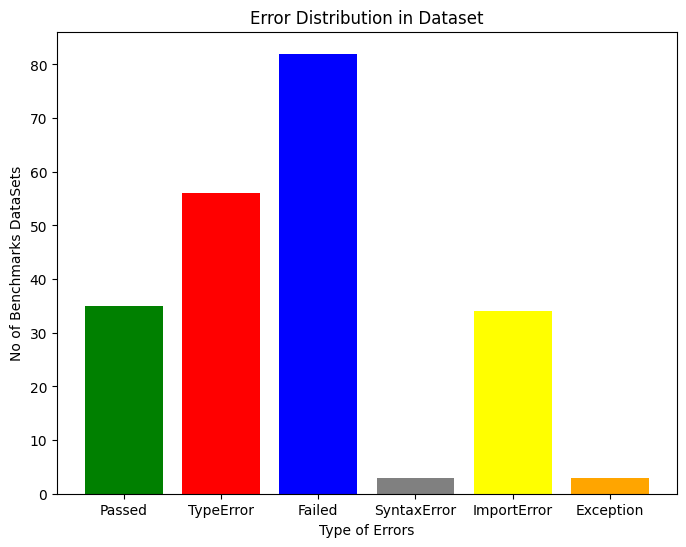

Pass : 35

TypeError : 56

Failed : 99

SyntaxError : 3

ImportError : 34

Exception : 4

Not Eligile for Evalution : 13


In [ ]:
Evalution_graph(fh1)
Pass = fh1.filter(lambda example: example['pass']>2).num_rows  # Replace with the actual number of cases that have passed
TypeError = fh1.filter(lambda example: example['TypeError']>2).num_rows
Failed= fh1.filter(lambda example: example['AssertionError']>2).num_rows
SyntaxError = fh1.filter(lambda example: example['SyntaxError']>2).num_rows
ImportError = fh1.filter(lambda example: example['ImportError']>2).num_rows
Exception = fh1.filter(lambda example: example['Exception']>2).num_rows

print("Pass :",Pass)
print("TypeError :",TypeError)
print("Failed :",Failed)
print("SyntaxError :",SyntaxError)
print("ImportError :",ImportError)
print("Exception :",Exception)
print("Not Eligile for Evalution :",test_benchmark_data['test'].filter(lambda example: example['output'] == "INVALID CODE ERROR WITH THE VALUE ").num_rows)

####**MODEL B**

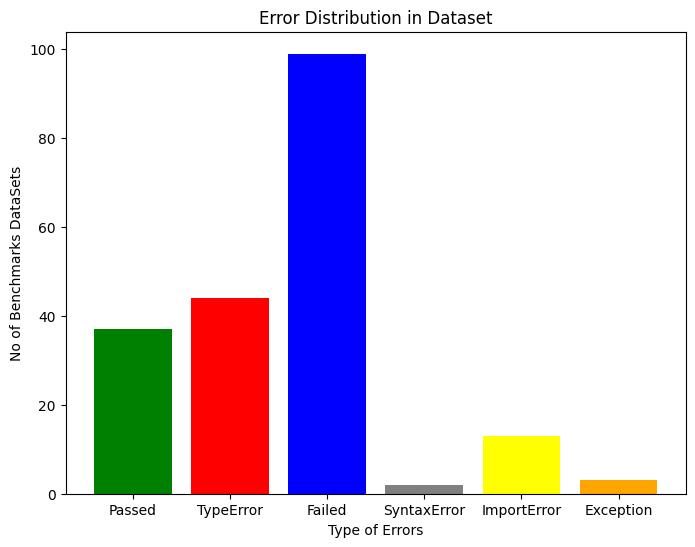

Pass : 37

TypeError : 44

Failed : 99

SyntaxError : 2

ImportError : 13

Exception : 3

Not Eligile for Evalution : 17


In [ ]:
Evalution_graph(fh1)
Pass = fh1.filter(lambda example: example['pass']>2).num_rows  # Replace with the actual number of cases that have passed
TypeError = fh1.filter(lambda example: example['TypeError']>2).num_rows
Failed= fh1.filter(lambda example: example['AssertionError']>2).num_rows
SyntaxError = fh1.filter(lambda example: example['SyntaxError']>2).num_rows
ImportError = fh1.filter(lambda example: example['ImportError']>2).num_rows
Exception = fh1.filter(lambda example: example['Exception']>2).num_rows

print("Pass :",Pass)
print("TypeError :",TypeError)
print("Failed :",Failed)
print("SyntaxError :",SyntaxError)
print("ImportError :",ImportError)
print("Exception :",Exception)
print("Not Eligile for Evalution :",test_benchmark_data['test'].filter(lambda example: example['output'] == "INVALID CODE ERROR WITH THE VALUE ").num_rows)

####**MODEL_A**

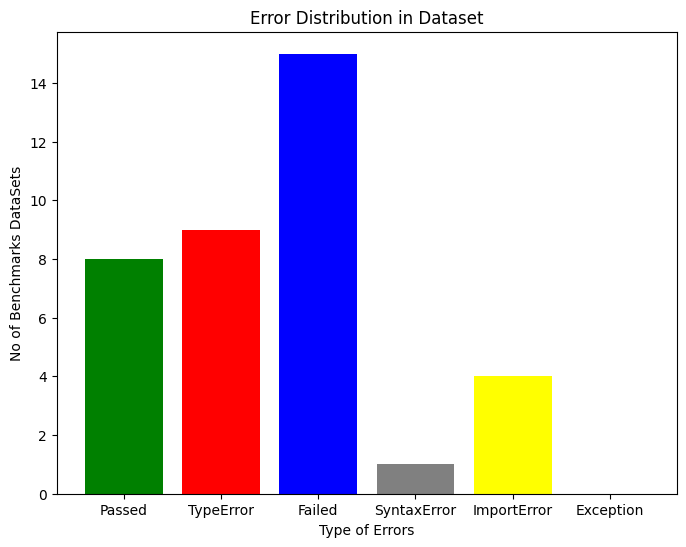

Pass : 8
TypeError : 9
Failed : 15
SyntaxError : 1
ImportError : 4
Exception : 0
Not Eligile for Evalution : 205


In [ ]:
Evalution_graph(fh1)
Pass = fh1.filter(lambda example: example['pass']>2).num_rows  # Replace with the actual number of cases that have passed
TypeError = fh1.filter(lambda example: example['TypeError']>2).num_rows
Failed= fh1.filter(lambda example: example['AssertionError']>2).num_rows
SyntaxError = fh1.filter(lambda example: example['SyntaxError']>2).num_rows
ImportError = fh1.filter(lambda example: example['ImportError']>2).num_rows
Exception = fh1.filter(lambda example: example['Exception']>2).num_rows

print("Pass :",Pass)
print("TypeError :",TypeError)
print("Failed :",Failed)
print("SyntaxError :",SyntaxError)
print("ImportError :",ImportError)
print("Exception :",Exception)
print("Not Eligile for Evalution :",test_benchmark_data['test'].filter(lambda example: example['output'] == "INVALID CODE ERROR WITH THE VALUE ").num_rows)

####**MODEL_A**

In [ ]:

result = calc_codebleu(test_benchmark_data_code_Model_A['code'],test_benchmark_data_code_Model_A['output'], lang="python", weights=(0.25, 0.25, 0.25, 0.25))
print(result)

/opt/conda/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


{'codebleu': 0.012713949088107662, 'ngram_match_score': 0.00018838624123508518, 'weighted_ngram_match_score': 0.0008339972451668676, 'syntax_match_score': 0.020121028744326776, 'dataflow_match_score': 0.029712384121701924}


####**MODEL_B**

In [ ]:

result = calc_codebleu(test_benchmark_data_code_Model_B['code'],test_benchmark_data_code_Model_B['output'], lang="python", weights=(0.25, 0.25, 0.25, 0.25))
print(result)

{'codebleu': 0.16639730677716932, 'ngram_match_score': 0.05289985419132543, 'weighted_ngram_match_score': 0.061518660032300054, 'syntax_match_score': 0.21815431164901664, 'dataflow_match_score': 0.33301640123603515}


####**MODEL_C**

In [ ]:
result = calc_codebleu(test_benchmark_data_code_Model_C['code'],test_benchmark_data_code_Model_C['output'], lang="python", weights=(0.25, 0.25, 0.25, 0.25))
print(result)

{'codebleu': 0.1418412346763709, 'ngram_match_score': 0.03336833526783325, 'weighted_ngram_match_score': 0.040028478128165026, 'syntax_match_score': 0.19470499243570347, 'dataflow_match_score': 0.2992631328737818}


####**MODEL_D**

In [ ]:
result = calc_codebleu(test_benchmark_data_code_Model_D['code'],test_benchmark_data_code_Model_D['output'], lang="python", weights=(0.25, 0.25, 0.25, 0.25))
print(result)

{'codebleu': 0.1668111893673984, 'ngram_match_score': 0.06446234029635925, 'weighted_ngram_match_score': 0.0765926541998455, 'syntax_match_score': 0.21195158850226928, 'dataflow_match_score': 0.31423817447111957}


##**CREATE A INTERFACE**

In [4]:
from peft import AutoPeftModelForCausalLM
model = AutoPeftModelForCausalLM.from_pretrained("LLMLover/MODEL_EPOCHS_D2_testcase_2", torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained("LLMLover/MODEL_EPOCHS_D2_testcase_2")
new_model_name_D = "MODEL_D"
model.save_pretrained(new_model_name_D)
tokenizer.save_pretrained(new_model_name_D)

content= '''

import streamlit as st
import textwrap
import numpy as np
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer,BitsAndBytesConfig
import torch
import re

models = {
    "Model_D": "LLMLover/MODEL_EPOCHS_D2_testcase_2"
#    "Model_D": "Model_D"
}

def get_model():
    model = AutoPeftModelForCausalLM.from_pretrained("MODEL_D", torch_dtype=torch.float16, load_in_4bit=True)
    tokenizer = AutoTokenizer.from_pretrained("MODEL_D")
    return tokenizer, model

def main():

    st.title("BOTH THE MODEL HAS SAME OR EVEN RESULT IN THE MY EVALUATION")
    st.title("EITHER SELECT MODEL B AND MODEL D")
    selected_model = st.selectbox("PLEASE SELECT A MODEL", list(models.keys()))
    model_name = models[selected_model]
    tokenizer, model = get_model()

    user_input = st.text_area("ENTER THE PYTHON QUESTION")
    button = st.button("Analyze")

    if user_input and button:
        Introduction_Sentence = "Below is an Python Programing question that describes a task. Write a Code for the same:"
        user_Input = "Input:"
        Response_Text = "### Response:"

        Introduction = f"{Introduction_Sentence}"
        input_context = f"{user_Input}\\n{user_input}"
        response = f"{Response_Text}\\n"

        parts = [part for part in [Introduction,input_context, response] if part]
        prompt= "\\n\\n".join(parts)
        input_ids = tokenizer(prompt, return_tensors='pt',padding=True,truncation=True)
        outputs = model.generate(**input_ids, max_new_tokens=256, temperature=0.7, top_p=0.6)

        output= tokenizer.decode(outputs[0][len(input_ids["input_ids"][0]):], skip_special_tokens=True)

        pattern = r'def\s+\w+\([^)]*\):\s*([\s\S]*?)\s*### End'
        pattern_2 = r'from\s+(\w+(\.\w+)*)\s*import\s+(\w+(,\s*\w+)*)\s*(as\s+\w+)?(?:,\s*(\w+(,\s*\w+)*)\s*(as\s+\w+)?)*'

        match = re.search(pattern, output.strip())
        match_2 = re.search(pattern_2, output.strip())

        if match:
            def_statement = match.group(0)
            if match_2:
                extra_code=match_2.group(0)
                combined_code = extra_code + "\\n" + def_statement
                response=combined_code
            else:
                response=def_statement

        else:
            match = re.search(r"def\s+(\w+)\s*\((.*)\):\s*return\s*(.*)", output.strip())
            if match:
                def_statement = match.group(0)
                if match_2:
                    extra_code=match_2.group(0)
                    combined_code = extra_code + "\\n" + def_statement
                    response=combined_code
                else:
                    response=def_statement
            else:
                response="INVALID CODE ERROR WITH THE VALUE "

        st.write(f"THIS IS THE PREDICTION: \\n {textwrap.dedent(response)}")

if __name__ == "__main__":
    main()
'''

with open("custome_model_B_D.py", 'w') as files:
    files.write(content)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

adapter_model.safetensors:   0%|          | 0.00/649M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

In [5]:
!streamlit run custome_model_B_D.py &>/content/logs.txt &
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

104.196.239.34
npx: installed 22 in 3.843s
your url is: https://cold-parts-carry.loca.lt


#For Reference for output of all Models

In [ ]:
# test_benchmark_data_code_Model_A = load_dataset('LLMLover/Testing_data12_A_23')['test']
# test_benchmark_data_code_Model_B = load_dataset('LLMLover/Testing_data12_B')['test']
# test_benchmark_data_code_Model_C = load_dataset('LLMLover/Testing_data12_C_23')['test']
# test_benchmark_data_code_Model_D = load_dataset('LLMLover/Testing_data12_D_23')['test']